In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import sys
sys.path.append('..')
import functools

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [157]:
dim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

In [158]:
xdata = (2*(sobol_seq.i4_sobol_generate(2,40)-0.5))*2 #[-1,1] cube
ydata = exponential_quartic(xdata)
xdata_ = torch.tensor(xdata,dtype=torch.float32)

In [159]:
gp = bvbq_torch.gp.SimpleGP(2,kind='smatern32',noise=1e-2)
gp.set_data(xdata,ydata)
gp.mean = -10.0
gp.fix_mean()
gp.fix_noise()
gp.optimize_params(tol=1e-1)

tensor(1., grad_fn=<LogBackward>) tensor(1., grad_fn=<LogBackward>)
tensor(1.6951, grad_fn=<LogBackward>) tensor(0.8158, grad_fn=<LogBackward>)
tensor(2.4061, grad_fn=<LogBackward>) tensor(0.9763, grad_fn=<LogBackward>)
tensor(3.2751, grad_fn=<LogBackward>) tensor(0.9651, grad_fn=<LogBackward>)
tensor(4.3665, grad_fn=<LogBackward>) tensor(1.0304, grad_fn=<LogBackward>)
tensor(5.7153, grad_fn=<LogBackward>) tensor(1.0554, grad_fn=<LogBackward>)
tensor(7.4656, grad_fn=<LogBackward>) tensor(1.2192, grad_fn=<LogBackward>)


{'raw_theta': tensor(7.4650), 'raw_lengthscale': tensor(0.8689)}

If tensor has more than 2 dimensions, only diagonal of covariance is returned
torch.Size([2500, 2])


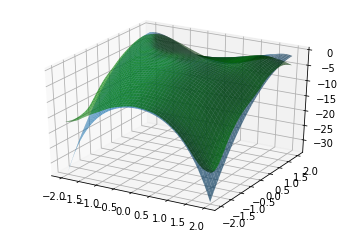

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-2,2)
y = np.linspace(-2,2)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

Zreg = gp.predict(np.stack([X,Y],axis=-1),istensor=False)[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [161]:
mixmeans = torch.randn((6,2))*0.1
mixvars = torch.distributions.HalfNormal(1.0).rsample((6,2))
mixweights = torch.distributions.Dirichlet(torch.ones(6)/3).rsample()
distributions = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)

In [186]:
exponential_quartic(distrib.sample(10000)).mean()

tensor(-3.0597)

In [201]:
bvbq_torch.bayesquad.monte_carlo_bayesian_quadrature(gp,distrib,10000)

(tensor(-2.4662), tensor(0.0636))

In [199]:
bvbq_torch.bayesquad.separable_mixdmvn_bq(gp,*distrib.params,nhermite=50)

(tensor(-2.3925), tensor(0.0085))

In [200]:
gp.predict(distrib.sample(100000),return_cov=False).mean()

-2.394198